In [1]:
import pandas as pd
import math
import os.path
import time
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
from progressbar import progressbar

import json
import ccxt

In [16]:


### API
bitmex_api_key = "[REDACTED]"    #Enter your own API-key here
bitmex_api_secret = "[REDACTED]" #Enter your own API-secret here
binance_api_key = "[REDACTED]"    #Enter your own API-key here
binance_api_secret = "[REDACTED]" #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '../data/binance_complete/%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): 
        print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: 
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return None #data_df

def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in range(rounds):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

C:\Python310\lib\site-packages\swagger_spec_validator\validator20.py:48: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  warnings.warn(


In [3]:
config = json.load(open('../logger_config.json'))

EXCHANGE = ccxt.binance({
    "apiKey": config["BINANCE_API_KEY"],
    "secret": config["BINANCE_SECRET_KEY"]
})


In [4]:
symbols = EXCHANGE.loadMarkets().keys()

In [14]:
symbols_usdt = [symbol.replace("/", "") for symbol in symbols if "/USDT" in symbol]
# symbols_usdt
# symbols_usdt = [ for symbol in symbols if "/USDT" in symbol]

In [17]:
import time
from tqdm import tqdm

# test_list = ["ETHUSDT", "LRCUSDT", "LTCUSDT"]

for symbol in tqdm(symbols_usdt):
    try:
        get_all_binance(symbol, "1h", save=True)
    except Exception as e:
        print(f"{symbol} could not be downloaded")
        print(e)

  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 1/376 [00:01<06:40,  1.07s/it]

All caught up..!


  1%|          | 2/376 [00:02<06:39,  1.07s/it]

All caught up..!


  1%|          | 3/376 [00:03<06:33,  1.06s/it]

All caught up..!


  1%|          | 4/376 [00:04<06:26,  1.04s/it]

All caught up..!


  1%|▏         | 5/376 [00:05<06:23,  1.03s/it]

All caught up..!


  2%|▏         | 6/376 [00:06<06:21,  1.03s/it]

All caught up..!


  2%|▏         | 7/376 [00:07<07:08,  1.16s/it]

All caught up..!


  2%|▏         | 8/376 [00:08<06:47,  1.11s/it]

All caught up..!


  2%|▏         | 9/376 [00:09<06:33,  1.07s/it]

All caught up..!


  3%|▎         | 10/376 [00:10<06:22,  1.05s/it]

All caught up..!


  3%|▎         | 11/376 [00:11<06:14,  1.03s/it]

All caught up..!


  3%|▎         | 12/376 [00:12<06:09,  1.02s/it]

All caught up..!


  3%|▎         | 13/376 [00:13<06:05,  1.01s/it]

All caught up..!


  4%|▎         | 14/376 [00:14<06:01,  1.00it/s]

All caught up..!


  4%|▍         | 15/376 [00:15<05:59,  1.00it/s]

All caught up..!


  4%|▍         | 16/376 [00:16<05:56,  1.01it/s]

All caught up..!


  5%|▍         | 17/376 [00:18<07:27,  1.25s/it]

All caught up..!


  5%|▍         | 18/376 [00:19<08:02,  1.35s/it]

All caught up..!


  5%|▌         | 19/376 [00:21<08:29,  1.43s/it]

All caught up..!


  5%|▌         | 20/376 [00:23<08:27,  1.43s/it]

All caught up..!


  6%|▌         | 21/376 [00:23<07:35,  1.28s/it]

All caught up..!


  6%|▌         | 22/376 [00:24<06:50,  1.16s/it]

All caught up..!


  6%|▌         | 23/376 [00:25<05:11,  1.13it/s]

BSVUSDT could not be downloaded
APIError(code=-1121): Invalid symbol.


  6%|▋         | 24/376 [00:58<1:02:23, 10.63s/it]

All caught up..!


  7%|▋         | 25/376 [01:30<1:40:09, 17.12s/it]

All caught up..!


  7%|▋         | 26/376 [02:02<2:06:25, 21.67s/it]

All caught up..!


  7%|▋         | 27/376 [02:38<2:30:36, 25.89s/it]

All caught up..!


  7%|▋         | 28/376 [02:52<2:08:21, 22.13s/it]

All caught up..!


  8%|▊         | 29/376 [03:24<2:25:32, 25.17s/it]

All caught up..!


  8%|▊         | 30/376 [03:56<2:36:30, 27.14s/it]

All caught up..!


  8%|▊         | 31/376 [04:28<2:45:11, 28.73s/it]

All caught up..!


  9%|▊         | 32/376 [04:59<2:49:21, 29.54s/it]

All caught up..!


  9%|▉         | 33/376 [05:33<2:56:04, 30.80s/it]

All caught up..!


  9%|▉         | 34/376 [06:04<2:56:11, 30.91s/it]

All caught up..!


  9%|▉         | 35/376 [06:37<2:58:58, 31.49s/it]

All caught up..!


 10%|▉         | 36/376 [07:07<2:55:49, 31.03s/it]

All caught up..!


 10%|▉         | 37/376 [07:40<2:58:38, 31.62s/it]

All caught up..!


 10%|█         | 38/376 [08:10<2:55:49, 31.21s/it]

All caught up..!


 10%|█         | 39/376 [08:44<2:59:16, 31.92s/it]

All caught up..!


 11%|█         | 40/376 [09:13<2:54:09, 31.10s/it]

All caught up..!


 11%|█         | 41/376 [09:47<2:57:53, 31.86s/it]

All caught up..!


 11%|█         | 42/376 [10:16<2:53:42, 31.20s/it]

All caught up..!


 11%|█▏        | 43/376 [10:47<2:52:11, 31.02s/it]

All caught up..!


 12%|█▏        | 44/376 [11:17<2:50:00, 30.72s/it]

All caught up..!


 12%|█▏        | 45/376 [11:50<2:53:38, 31.47s/it]

All caught up..!


 12%|█▏        | 46/376 [12:19<2:48:11, 30.58s/it]

All caught up..!


 12%|█▎        | 47/376 [12:51<2:50:32, 31.10s/it]

All caught up..!


 13%|█▎        | 48/376 [13:19<2:43:56, 29.99s/it]

All caught up..!


 13%|█▎        | 49/376 [13:49<2:43:50, 30.06s/it]

All caught up..!


 13%|█▎        | 50/376 [14:17<2:39:41, 29.39s/it]

All caught up..!


 14%|█▎        | 51/376 [14:19<1:55:47, 21.38s/it]

All caught up..!


 14%|█▍        | 52/376 [14:50<2:09:53, 24.05s/it]

All caught up..!


 14%|█▍        | 53/376 [15:02<1:50:02, 20.44s/it]

All caught up..!


 14%|█▍        | 54/376 [15:28<1:59:06, 22.19s/it]

All caught up..!


 15%|█▍        | 55/376 [15:58<2:11:58, 24.67s/it]

All caught up..!


 15%|█▍        | 56/376 [16:25<2:15:08, 25.34s/it]

All caught up..!


 15%|█▌        | 57/376 [16:57<2:24:29, 27.18s/it]

All caught up..!


 15%|█▌        | 58/376 [17:24<2:23:50, 27.14s/it]

All caught up..!


 16%|█▌        | 59/376 [17:43<2:11:33, 24.90s/it]

All caught up..!


 16%|█▌        | 60/376 [18:09<2:11:38, 25.00s/it]

All caught up..!


 16%|█▌        | 61/376 [18:33<2:10:50, 24.92s/it]

All caught up..!


 16%|█▋        | 62/376 [19:02<2:16:25, 26.07s/it]

All caught up..!


 17%|█▋        | 63/376 [19:27<2:14:15, 25.74s/it]

All caught up..!


 17%|█▋        | 64/376 [19:55<2:17:40, 26.48s/it]

All caught up..!


 17%|█▋        | 65/376 [20:19<2:13:38, 25.78s/it]

All caught up..!


 18%|█▊        | 66/376 [20:46<2:13:56, 25.93s/it]

All caught up..!


 18%|█▊        | 67/376 [20:54<1:46:20, 20.65s/it]

All caught up..!


 18%|█▊        | 68/376 [21:19<1:52:00, 21.82s/it]

All caught up..!


 18%|█▊        | 69/376 [21:46<2:00:13, 23.50s/it]

All caught up..!


 19%|█▊        | 70/376 [22:12<2:03:48, 24.28s/it]

All caught up..!


 19%|█▉        | 71/376 [22:38<2:05:52, 24.76s/it]

All caught up..!


 19%|█▉        | 72/376 [23:05<2:08:23, 25.34s/it]

All caught up..!


 19%|█▉        | 73/376 [23:29<2:05:45, 24.90s/it]

All caught up..!


 20%|█▉        | 74/376 [23:57<2:10:35, 25.95s/it]

All caught up..!


 20%|█▉        | 75/376 [24:21<2:07:21, 25.39s/it]

All caught up..!


 20%|██        | 76/376 [24:50<2:12:57, 26.59s/it]

All caught up..!


 20%|██        | 77/376 [25:15<2:10:10, 26.12s/it]

All caught up..!


 21%|██        | 78/376 [25:39<2:06:36, 25.49s/it]

All caught up..!


 21%|██        | 79/376 [25:55<1:51:00, 22.43s/it]

All caught up..!


 21%|██▏       | 80/376 [26:19<1:53:26, 22.99s/it]

All caught up..!


 22%|██▏       | 81/376 [26:46<1:58:36, 24.12s/it]

All caught up..!


 22%|██▏       | 82/376 [27:09<1:57:14, 23.93s/it]

All caught up..!


 22%|██▏       | 83/376 [27:32<1:55:26, 23.64s/it]

All caught up..!


 22%|██▏       | 84/376 [27:58<1:58:07, 24.27s/it]

All caught up..!


 23%|██▎       | 85/376 [28:20<1:54:33, 23.62s/it]

All caught up..!


 23%|██▎       | 86/376 [28:44<1:54:47, 23.75s/it]

All caught up..!


 23%|██▎       | 87/376 [28:57<1:39:13, 20.60s/it]

All caught up..!


 23%|██▎       | 88/376 [29:21<1:43:16, 21.51s/it]

All caught up..!


 24%|██▎       | 89/376 [29:45<1:45:48, 22.12s/it]

All caught up..!


 24%|██▍       | 90/376 [30:11<1:51:30, 23.39s/it]

All caught up..!


 24%|██▍       | 91/376 [30:33<1:48:58, 22.94s/it]

All caught up..!


 24%|██▍       | 92/376 [30:59<1:53:11, 23.91s/it]

All caught up..!


 25%|██▍       | 93/376 [31:20<1:48:17, 22.96s/it]

All caught up..!


 25%|██▌       | 94/376 [31:40<1:44:12, 22.17s/it]

All caught up..!


 25%|██▌       | 95/376 [31:43<1:16:11, 16.27s/it]

All caught up..!


 26%|██▌       | 96/376 [31:46<57:53, 12.41s/it]  

All caught up..!


 26%|██▌       | 97/376 [31:49<44:49,  9.64s/it]

All caught up..!


 26%|██▌       | 98/376 [31:51<33:16,  7.18s/it]

All caught up..!


 26%|██▋       | 99/376 [32:13<54:02, 11.71s/it]

All caught up..!


 27%|██▋       | 100/376 [32:33<1:05:29, 14.24s/it]

All caught up..!


 27%|██▋       | 101/376 [32:58<1:19:55, 17.44s/it]

All caught up..!


 27%|██▋       | 102/376 [33:18<1:23:37, 18.31s/it]

All caught up..!


 27%|██▋       | 103/376 [33:38<1:25:52, 18.87s/it]

All caught up..!


 28%|██▊       | 104/376 [34:03<1:32:40, 20.44s/it]

All caught up..!


 28%|██▊       | 105/376 [34:04<1:06:19, 14.69s/it]

All caught up..!


 28%|██▊       | 106/376 [34:05<47:54, 10.65s/it]  

All caught up..!


 28%|██▊       | 107/376 [34:06<35:20,  7.88s/it]

All caught up..!


 29%|██▊       | 108/376 [34:08<26:19,  5.89s/it]

All caught up..!


 29%|██▉       | 109/376 [34:16<29:19,  6.59s/it]

All caught up..!


 29%|██▉       | 110/376 [34:36<47:14, 10.66s/it]

All caught up..!


 30%|██▉       | 111/376 [34:59<1:03:24, 14.36s/it]

All caught up..!


 30%|██▉       | 112/376 [35:18<1:09:15, 15.74s/it]

All caught up..!


 30%|███       | 113/376 [35:19<49:17, 11.24s/it]  

All caught up..!


 30%|███       | 114/376 [35:20<35:19,  8.09s/it]

All caught up..!


 31%|███       | 115/376 [35:38<48:54, 11.25s/it]

All caught up..!


 31%|███       | 116/376 [36:01<1:03:31, 14.66s/it]

All caught up..!


 31%|███       | 117/376 [36:20<1:09:06, 16.01s/it]

All caught up..!


 31%|███▏      | 118/376 [36:28<59:12, 13.77s/it]  

All caught up..!


 32%|███▏      | 119/376 [36:44<1:00:37, 14.15s/it]

All caught up..!


 32%|███▏      | 120/376 [37:05<1:09:10, 16.21s/it]

All caught up..!


 32%|███▏      | 121/376 [37:22<1:10:35, 16.61s/it]

All caught up..!


 32%|███▏      | 122/376 [37:39<1:10:56, 16.76s/it]

All caught up..!


 33%|███▎      | 123/376 [38:00<1:16:13, 18.08s/it]

All caught up..!


 33%|███▎      | 124/376 [38:20<1:17:23, 18.43s/it]

All caught up..!


 33%|███▎      | 125/376 [38:37<1:15:33, 18.06s/it]

All caught up..!


 34%|███▎      | 126/376 [38:57<1:17:38, 18.63s/it]

All caught up..!


 34%|███▍      | 127/376 [39:04<1:02:54, 15.16s/it]

All caught up..!


 34%|███▍      | 128/376 [39:23<1:07:20, 16.29s/it]

All caught up..!


 34%|███▍      | 129/376 [39:40<1:07:43, 16.45s/it]

All caught up..!


 35%|███▍      | 130/376 [40:00<1:11:47, 17.51s/it]

All caught up..!


 35%|███▍      | 131/376 [40:19<1:14:19, 18.20s/it]

All caught up..!


 35%|███▌      | 132/376 [40:36<1:12:17, 17.78s/it]

All caught up..!


 35%|███▌      | 133/376 [40:53<1:10:51, 17.50s/it]

All caught up..!


 36%|███▌      | 134/376 [41:15<1:15:34, 18.74s/it]

All caught up..!


 36%|███▌      | 135/376 [41:16<54:37, 13.60s/it]  

All caught up..!


 36%|███▌      | 136/376 [41:33<58:17, 14.57s/it]

All caught up..!


 36%|███▋      | 137/376 [41:49<59:51, 15.03s/it]

All caught up..!


 37%|███▋      | 138/376 [42:08<1:04:16, 16.20s/it]

All caught up..!


 37%|███▋      | 139/376 [42:25<1:04:24, 16.30s/it]

All caught up..!


 37%|███▋      | 140/376 [42:40<1:03:07, 16.05s/it]

All caught up..!


 38%|███▊      | 141/376 [42:57<1:03:44, 16.28s/it]

All caught up..!


 38%|███▊      | 142/376 [43:17<1:07:57, 17.43s/it]

All caught up..!


 38%|███▊      | 143/376 [43:32<1:05:20, 16.83s/it]

All caught up..!


 38%|███▊      | 144/376 [43:47<1:02:59, 16.29s/it]

All caught up..!


 39%|███▊      | 145/376 [44:05<1:03:53, 16.59s/it]

All caught up..!


 39%|███▉      | 146/376 [44:20<1:01:52, 16.14s/it]

All caught up..!


 39%|███▉      | 147/376 [44:35<1:00:15, 15.79s/it]

All caught up..!


 39%|███▉      | 148/376 [44:50<59:14, 15.59s/it]  

All caught up..!


 40%|███▉      | 149/376 [45:09<1:02:26, 16.51s/it]

All caught up..!


 40%|███▉      | 150/376 [45:09<44:21, 11.78s/it]  

All caught up..!


 40%|████      | 151/376 [45:25<48:24, 12.91s/it]

All caught up..!


 40%|████      | 152/376 [45:40<50:38, 13.57s/it]

All caught up..!


 41%|████      | 153/376 [45:55<51:51, 13.95s/it]

All caught up..!


 41%|████      | 154/376 [46:13<56:35, 15.30s/it]

All caught up..!


 41%|████      | 155/376 [46:31<58:33, 15.90s/it]

All caught up..!


 41%|████▏     | 156/376 [46:46<57:23, 15.65s/it]

All caught up..!


 42%|████▏     | 157/376 [47:01<57:11, 15.67s/it]

All caught up..!


 42%|████▏     | 158/376 [47:18<57:52, 15.93s/it]

All caught up..!


 42%|████▏     | 159/376 [47:33<56:58, 15.75s/it]

All caught up..!


 43%|████▎     | 160/376 [47:48<55:56, 15.54s/it]

All caught up..!


 43%|████▎     | 161/376 [48:05<57:09, 15.95s/it]

All caught up..!


 43%|████▎     | 162/376 [48:23<58:42, 16.46s/it]

All caught up..!


 43%|████▎     | 163/376 [48:38<57:16, 16.13s/it]

All caught up..!


 44%|████▎     | 164/376 [48:53<55:53, 15.82s/it]

All caught up..!


 44%|████▍     | 165/376 [49:12<58:31, 16.64s/it]

All caught up..!


 44%|████▍     | 166/376 [49:27<56:26, 16.13s/it]

All caught up..!


 44%|████▍     | 167/376 [49:42<54:52, 15.75s/it]

All caught up..!


 45%|████▍     | 168/376 [49:57<53:41, 15.49s/it]

All caught up..!


 45%|████▍     | 169/376 [50:16<57:47, 16.75s/it]

All caught up..!


 45%|████▌     | 170/376 [50:32<56:31, 16.46s/it]

All caught up..!


 45%|████▌     | 171/376 [50:49<56:33, 16.55s/it]

All caught up..!


 46%|████▌     | 172/376 [51:06<56:54, 16.74s/it]

All caught up..!


 46%|████▌     | 173/376 [51:21<54:35, 16.13s/it]

All caught up..!


 46%|████▋     | 174/376 [51:35<52:08, 15.49s/it]

All caught up..!


 47%|████▋     | 175/376 [51:48<49:54, 14.90s/it]

All caught up..!


 47%|████▋     | 176/376 [52:05<51:58, 15.59s/it]

All caught up..!


 47%|████▋     | 177/376 [52:23<53:15, 16.06s/it]

All caught up..!


 47%|████▋     | 178/376 [52:37<51:34, 15.63s/it]

All caught up..!


 48%|████▊     | 179/376 [52:51<49:13, 14.99s/it]

All caught up..!


 48%|████▊     | 180/376 [53:07<50:43, 15.53s/it]

All caught up..!


 48%|████▊     | 181/376 [53:22<49:58, 15.38s/it]

All caught up..!


 48%|████▊     | 182/376 [53:36<47:55, 14.82s/it]

All caught up..!


 49%|████▊     | 183/376 [53:50<46:31, 14.46s/it]

All caught up..!


 49%|████▉     | 184/376 [54:05<47:07, 14.73s/it]

All caught up..!


 49%|████▉     | 185/376 [54:21<47:59, 15.08s/it]

All caught up..!


 49%|████▉     | 186/376 [54:35<46:30, 14.69s/it]

All caught up..!


 50%|████▉     | 187/376 [54:49<46:23, 14.73s/it]

All caught up..!


 50%|█████     | 188/376 [55:07<48:29, 15.48s/it]

All caught up..!


 50%|█████     | 189/376 [55:24<50:04, 16.07s/it]

All caught up..!


 51%|█████     | 190/376 [55:38<48:11, 15.55s/it]

All caught up..!


 51%|█████     | 191/376 [55:52<46:16, 15.01s/it]

All caught up..!


 51%|█████     | 192/376 [56:09<47:16, 15.41s/it]

All caught up..!


 51%|█████▏    | 193/376 [56:24<46:56, 15.39s/it]

All caught up..!


 52%|█████▏    | 194/376 [56:39<46:09, 15.22s/it]

All caught up..!


 52%|█████▏    | 195/376 [56:53<45:16, 15.01s/it]

All caught up..!


 52%|█████▏    | 196/376 [57:10<46:17, 15.43s/it]

All caught up..!


 52%|█████▏    | 197/376 [57:25<46:17, 15.52s/it]

All caught up..!


 53%|█████▎    | 198/376 [57:39<44:14, 14.91s/it]

All caught up..!


 53%|█████▎    | 199/376 [57:53<43:19, 14.69s/it]

All caught up..!


 53%|█████▎    | 200/376 [58:08<43:40, 14.89s/it]

All caught up..!


 53%|█████▎    | 201/376 [58:24<44:23, 15.22s/it]

All caught up..!


 54%|█████▎    | 202/376 [58:38<42:43, 14.73s/it]

All caught up..!


 54%|█████▍    | 203/376 [58:52<41:35, 14.42s/it]

All caught up..!


 54%|█████▍    | 204/376 [59:07<41:45, 14.57s/it]

All caught up..!


 55%|█████▍    | 205/376 [59:23<42:51, 15.04s/it]

All caught up..!


 55%|█████▍    | 206/376 [59:36<41:15, 14.56s/it]

All caught up..!


 55%|█████▌    | 207/376 [59:50<40:37, 14.42s/it]

All caught up..!


 55%|█████▌    | 208/376 [1:00:04<39:32, 14.12s/it]

All caught up..!


 56%|█████▌    | 209/376 [1:00:24<44:47, 16.09s/it]

All caught up..!


 56%|█████▌    | 210/376 [1:00:38<42:10, 15.24s/it]

All caught up..!


 56%|█████▌    | 211/376 [1:00:52<40:55, 14.88s/it]

All caught up..!


 56%|█████▋    | 212/376 [1:01:05<39:13, 14.35s/it]

All caught up..!


 57%|█████▋    | 213/376 [1:01:19<38:47, 14.28s/it]

All caught up..!


 57%|█████▋    | 214/376 [1:01:31<37:03, 13.72s/it]

All caught up..!


 57%|█████▋    | 215/376 [1:01:45<36:25, 13.57s/it]

All caught up..!


 57%|█████▋    | 216/376 [1:01:58<36:27, 13.67s/it]

All caught up..!


 58%|█████▊    | 217/376 [1:02:15<38:47, 14.64s/it]

All caught up..!


 58%|█████▊    | 218/376 [1:02:30<38:21, 14.57s/it]

All caught up..!


 58%|█████▊    | 219/376 [1:02:42<36:31, 13.96s/it]

All caught up..!


 59%|█████▊    | 220/376 [1:02:56<36:22, 13.99s/it]

All caught up..!


 59%|█████▉    | 221/376 [1:03:10<36:00, 13.94s/it]

All caught up..!


 59%|█████▉    | 222/376 [1:03:26<37:14, 14.51s/it]

All caught up..!


 59%|█████▉    | 223/376 [1:03:35<32:47, 12.86s/it]

All caught up..!


 60%|█████▉    | 224/376 [1:03:45<30:03, 11.87s/it]

All caught up..!


 60%|█████▉    | 225/376 [1:03:57<29:59, 11.92s/it]

All caught up..!


 60%|██████    | 226/376 [1:04:08<29:42, 11.88s/it]

All caught up..!


 60%|██████    | 227/376 [1:04:22<30:25, 12.25s/it]

All caught up..!


 61%|██████    | 228/376 [1:04:34<30:35, 12.40s/it]

All caught up..!


 61%|██████    | 229/376 [1:04:46<29:59, 12.24s/it]

All caught up..!


 61%|██████    | 230/376 [1:04:58<29:18, 12.04s/it]

All caught up..!


 61%|██████▏   | 231/376 [1:05:12<30:22, 12.57s/it]

All caught up..!


 62%|██████▏   | 232/376 [1:05:27<32:16, 13.45s/it]

All caught up..!


 62%|██████▏   | 233/376 [1:05:40<31:34, 13.25s/it]

All caught up..!


 62%|██████▏   | 234/376 [1:05:51<29:54, 12.64s/it]

All caught up..!


 62%|██████▎   | 235/376 [1:06:01<27:45, 11.81s/it]

All caught up..!


 63%|██████▎   | 236/376 [1:06:14<28:08, 12.06s/it]

All caught up..!


 63%|██████▎   | 237/376 [1:06:27<28:56, 12.49s/it]

All caught up..!


 63%|██████▎   | 238/376 [1:06:39<28:10, 12.25s/it]

All caught up..!


 64%|██████▎   | 239/376 [1:06:50<27:01, 11.83s/it]

All caught up..!


 64%|██████▍   | 240/376 [1:07:00<25:38, 11.31s/it]

All caught up..!


 64%|██████▍   | 241/376 [1:07:10<24:35, 10.93s/it]

All caught up..!


 64%|██████▍   | 242/376 [1:07:25<26:58, 12.08s/it]

All caught up..!


 65%|██████▍   | 243/376 [1:07:37<26:51, 12.11s/it]

All caught up..!


 65%|██████▍   | 244/376 [1:07:49<26:56, 12.24s/it]

All caught up..!


 65%|██████▌   | 245/376 [1:08:01<26:06, 11.95s/it]

All caught up..!


 65%|██████▌   | 246/376 [1:08:12<25:45, 11.89s/it]

All caught up..!


 66%|██████▌   | 247/376 [1:08:26<26:52, 12.50s/it]

All caught up..!


 66%|██████▌   | 248/376 [1:08:38<26:15, 12.31s/it]

All caught up..!


 66%|██████▌   | 249/376 [1:08:50<26:01, 12.30s/it]

All caught up..!


 66%|██████▋   | 250/376 [1:09:00<24:26, 11.64s/it]

All caught up..!


 67%|██████▋   | 251/376 [1:09:11<23:18, 11.19s/it]

All caught up..!


 67%|██████▋   | 252/376 [1:09:25<24:59, 12.09s/it]

All caught up..!


 67%|██████▋   | 253/376 [1:09:35<23:47, 11.60s/it]

All caught up..!


 68%|██████▊   | 254/376 [1:09:46<23:03, 11.34s/it]

All caught up..!


 68%|██████▊   | 255/376 [1:09:56<21:55, 10.87s/it]

All caught up..!


 68%|██████▊   | 256/376 [1:10:06<21:06, 10.55s/it]

All caught up..!


 68%|██████▊   | 257/376 [1:10:19<22:30, 11.35s/it]

All caught up..!


 69%|██████▊   | 258/376 [1:10:31<22:41, 11.54s/it]

All caught up..!


 69%|██████▉   | 259/376 [1:10:41<22:02, 11.30s/it]

All caught up..!


 69%|██████▉   | 260/376 [1:10:52<21:29, 11.12s/it]

All caught up..!


 69%|██████▉   | 261/376 [1:11:02<20:25, 10.65s/it]

All caught up..!


 70%|██████▉   | 262/376 [1:11:11<19:36, 10.32s/it]

All caught up..!


 70%|██████▉   | 263/376 [1:11:24<20:39, 10.96s/it]

All caught up..!


 70%|███████   | 264/376 [1:11:33<19:23, 10.39s/it]

All caught up..!


 70%|███████   | 265/376 [1:11:42<18:26,  9.97s/it]

All caught up..!


 71%|███████   | 266/376 [1:11:51<17:36,  9.60s/it]

All caught up..!


 71%|███████   | 267/376 [1:11:59<16:59,  9.35s/it]

All caught up..!


 71%|███████▏  | 268/376 [1:12:08<16:21,  9.09s/it]

All caught up..!


 72%|███████▏  | 269/376 [1:12:17<16:23,  9.19s/it]

All caught up..!


 72%|███████▏  | 270/376 [1:12:28<17:14,  9.76s/it]

All caught up..!


 72%|███████▏  | 271/376 [1:12:37<16:25,  9.39s/it]

All caught up..!


 72%|███████▏  | 272/376 [1:12:45<15:54,  9.17s/it]

All caught up..!


 73%|███████▎  | 273/376 [1:12:54<15:29,  9.02s/it]

All caught up..!


 73%|███████▎  | 274/376 [1:13:02<14:50,  8.73s/it]

All caught up..!


 73%|███████▎  | 275/376 [1:13:11<14:50,  8.82s/it]

All caught up..!


 73%|███████▎  | 276/376 [1:13:22<15:44,  9.44s/it]

All caught up..!


 74%|███████▎  | 277/376 [1:13:33<16:10,  9.80s/it]

All caught up..!


 74%|███████▍  | 278/376 [1:13:39<14:24,  8.83s/it]

All caught up..!


 74%|███████▍  | 279/376 [1:13:46<13:17,  8.23s/it]

All caught up..!


 74%|███████▍  | 280/376 [1:13:54<13:03,  8.16s/it]

All caught up..!


 75%|███████▍  | 281/376 [1:14:02<12:45,  8.06s/it]

All caught up..!


 75%|███████▌  | 282/376 [1:14:10<12:29,  7.97s/it]

All caught up..!


 75%|███████▌  | 283/376 [1:14:20<13:28,  8.70s/it]

All caught up..!


 76%|███████▌  | 284/376 [1:14:31<14:13,  9.28s/it]

All caught up..!


 76%|███████▌  | 285/376 [1:14:39<13:47,  9.10s/it]

All caught up..!


 76%|███████▌  | 286/376 [1:14:49<13:45,  9.17s/it]

All caught up..!


 76%|███████▋  | 287/376 [1:14:55<12:26,  8.39s/it]

All caught up..!


 77%|███████▋  | 288/376 [1:15:02<11:28,  7.83s/it]

All caught up..!


 77%|███████▋  | 289/376 [1:15:08<10:46,  7.43s/it]

All caught up..!


 77%|███████▋  | 290/376 [1:15:15<10:13,  7.13s/it]

All caught up..!


 77%|███████▋  | 291/376 [1:15:25<11:28,  8.10s/it]

All caught up..!


 78%|███████▊  | 292/376 [1:15:32<10:48,  7.72s/it]

All caught up..!


 78%|███████▊  | 293/376 [1:15:39<10:11,  7.37s/it]

All caught up..!


 78%|███████▊  | 294/376 [1:15:45<09:39,  7.07s/it]

All caught up..!


 78%|███████▊  | 295/376 [1:15:52<09:36,  7.12s/it]

All caught up..!


 79%|███████▊  | 296/376 [1:15:58<09:10,  6.88s/it]

All caught up..!


 79%|███████▉  | 297/376 [1:16:05<08:48,  6.69s/it]

All caught up..!


 79%|███████▉  | 298/376 [1:16:11<08:37,  6.64s/it]

All caught up..!


 80%|███████▉  | 299/376 [1:16:17<08:19,  6.49s/it]

All caught up..!


 80%|███████▉  | 300/376 [1:16:25<08:42,  6.88s/it]

All caught up..!


 80%|████████  | 301/376 [1:16:33<09:05,  7.28s/it]

All caught up..!


 80%|████████  | 302/376 [1:16:39<08:31,  6.91s/it]

All caught up..!


 81%|████████  | 303/376 [1:16:46<08:14,  6.77s/it]

All caught up..!


 81%|████████  | 304/376 [1:16:53<08:09,  6.80s/it]

All caught up..!


 81%|████████  | 305/376 [1:16:57<07:18,  6.18s/it]

All caught up..!


 81%|████████▏ | 306/376 [1:17:02<06:43,  5.77s/it]

All caught up..!


 82%|████████▏ | 307/376 [1:17:07<06:13,  5.41s/it]

All caught up..!


 82%|████████▏ | 308/376 [1:17:12<06:08,  5.42s/it]

All caught up..!


 82%|████████▏ | 309/376 [1:17:17<05:49,  5.22s/it]

All caught up..!


 82%|████████▏ | 310/376 [1:17:25<06:39,  6.05s/it]

All caught up..!


 83%|████████▎ | 311/376 [1:17:31<06:36,  6.10s/it]

All caught up..!


 83%|████████▎ | 312/376 [1:17:37<06:14,  5.85s/it]

All caught up..!


 83%|████████▎ | 313/376 [1:17:41<05:47,  5.51s/it]

All caught up..!


 84%|████████▎ | 314/376 [1:17:46<05:24,  5.23s/it]

All caught up..!


 84%|████████▍ | 315/376 [1:17:51<05:13,  5.14s/it]

All caught up..!


 84%|████████▍ | 316/376 [1:17:55<04:53,  4.89s/it]

All caught up..!


 84%|████████▍ | 317/376 [1:17:59<04:39,  4.73s/it]

All caught up..!


 85%|████████▍ | 318/376 [1:18:04<04:30,  4.66s/it]

All caught up..!


 85%|████████▍ | 319/376 [1:18:08<04:20,  4.57s/it]

All caught up..!


 85%|████████▌ | 320/376 [1:18:13<04:12,  4.51s/it]

All caught up..!


 85%|████████▌ | 321/376 [1:18:17<04:04,  4.45s/it]

All caught up..!


 86%|████████▌ | 322/376 [1:18:22<04:18,  4.78s/it]

All caught up..!


 86%|████████▌ | 323/376 [1:18:29<04:39,  5.27s/it]

All caught up..!


 86%|████████▌ | 324/376 [1:18:33<04:19,  4.98s/it]

All caught up..!


 86%|████████▋ | 325/376 [1:18:38<04:05,  4.81s/it]

All caught up..!


 87%|████████▋ | 326/376 [1:18:41<03:37,  4.35s/it]

All caught up..!


 87%|████████▋ | 327/376 [1:18:45<03:32,  4.33s/it]

All caught up..!


 87%|████████▋ | 328/376 [1:18:49<03:13,  4.03s/it]

All caught up..!


 88%|████████▊ | 329/376 [1:18:52<02:54,  3.72s/it]

All caught up..!


 88%|████████▊ | 330/376 [1:18:54<02:40,  3.50s/it]

All caught up..!


 88%|████████▊ | 331/376 [1:18:57<02:30,  3.34s/it]

All caught up..!


 88%|████████▊ | 332/376 [1:19:01<02:23,  3.26s/it]

All caught up..!


 89%|████████▊ | 333/376 [1:19:04<02:16,  3.18s/it]

All caught up..!


 89%|████████▉ | 334/376 [1:19:07<02:11,  3.12s/it]

All caught up..!


 89%|████████▉ | 335/376 [1:19:09<02:03,  3.02s/it]

All caught up..!


 89%|████████▉ | 336/376 [1:19:12<01:57,  2.95s/it]

All caught up..!


 90%|████████▉ | 337/376 [1:19:15<01:53,  2.91s/it]

All caught up..!


 90%|████████▉ | 338/376 [1:19:18<01:49,  2.87s/it]

All caught up..!


 90%|█████████ | 339/376 [1:19:22<02:06,  3.41s/it]

All caught up..!


 90%|█████████ | 340/376 [1:19:27<02:20,  3.91s/it]

All caught up..!


 91%|█████████ | 341/376 [1:19:31<02:09,  3.70s/it]

All caught up..!


 91%|█████████ | 342/376 [1:19:34<02:00,  3.54s/it]

All caught up..!


 91%|█████████ | 343/376 [1:19:36<01:46,  3.22s/it]

All caught up..!


 91%|█████████▏| 344/376 [1:19:39<01:36,  3.01s/it]

All caught up..!


 92%|█████████▏| 345/376 [1:19:41<01:28,  2.86s/it]

All caught up..!


 92%|█████████▏| 346/376 [1:19:44<01:27,  2.92s/it]

All caught up..!


 92%|█████████▏| 347/376 [1:19:47<01:23,  2.86s/it]

All caught up..!


 93%|█████████▎| 348/376 [1:19:50<01:17,  2.76s/it]

All caught up..!


 93%|█████████▎| 349/376 [1:19:52<01:12,  2.68s/it]

All caught up..!


 93%|█████████▎| 350/376 [1:19:53<00:58,  2.25s/it]

All caught up..!


 93%|█████████▎| 351/376 [1:19:55<00:48,  1.95s/it]

All caught up..!


 94%|█████████▎| 352/376 [1:19:56<00:41,  1.74s/it]

All caught up..!


 94%|█████████▍| 353/376 [1:19:58<00:41,  1.79s/it]

All caught up..!


 94%|█████████▍| 354/376 [1:19:59<00:37,  1.69s/it]

All caught up..!


 94%|█████████▍| 355/376 [1:20:00<00:32,  1.55s/it]

All caught up..!


 95%|█████████▍| 356/376 [1:20:02<00:29,  1.46s/it]

All caught up..!


 95%|█████████▍| 357/376 [1:20:03<00:26,  1.39s/it]

All caught up..!


 95%|█████████▌| 358/376 [1:20:04<00:24,  1.34s/it]

All caught up..!


 95%|█████████▌| 359/376 [1:20:06<00:23,  1.37s/it]

All caught up..!


 96%|█████████▌| 360/376 [1:20:07<00:21,  1.34s/it]

All caught up..!


 96%|█████████▌| 361/376 [1:20:08<00:19,  1.31s/it]

All caught up..!


 96%|█████████▋| 362/376 [1:20:09<00:17,  1.22s/it]

All caught up..!


 97%|█████████▋| 363/376 [1:20:10<00:14,  1.15s/it]

All caught up..!


 97%|█████████▋| 364/376 [1:20:11<00:13,  1.11s/it]

All caught up..!


 97%|█████████▋| 365/376 [1:20:12<00:11,  1.08s/it]

All caught up..!


 97%|█████████▋| 366/376 [1:20:13<00:10,  1.05s/it]

All caught up..!


 98%|█████████▊| 367/376 [1:20:14<00:09,  1.03s/it]

All caught up..!


 98%|█████████▊| 368/376 [1:20:15<00:08,  1.02s/it]

All caught up..!


 98%|█████████▊| 369/376 [1:20:16<00:07,  1.01s/it]

All caught up..!


 98%|█████████▊| 370/376 [1:20:17<00:05,  1.00it/s]

All caught up..!


 99%|█████████▊| 371/376 [1:20:18<00:04,  1.08it/s]

All caught up..!


 99%|█████████▉| 372/376 [1:20:19<00:03,  1.15it/s]

All caught up..!


 99%|█████████▉| 373/376 [1:20:19<00:02,  1.18it/s]

All caught up..!


 99%|█████████▉| 374/376 [1:20:20<00:01,  1.13it/s]

All caught up..!


100%|█████████▉| 375/376 [1:20:22<00:01,  1.24s/it]

All caught up..!


100%|██████████| 376/376 [1:20:25<00:00, 12.83s/it]

All caught up..!


In [13]:
from joblib import Parallel, delayed

Parallel(n_jobs=-1)(delayed(get_all_binance)(symbol, "1h", save=True) for symbol in test_list)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [10]:
from math import sqrt
from joblib import Parallel, delayed

def test_function(input, string):
    
    return input * string

Parallel(n_jobs=2)(delayed(test_function)(i ** 2, 2) for i in range(10))

[0, 2, 8, 18, 32, 50, 72, 98, 128, 162]

In [24]:
df_bitmex = get_all_bitmex("XBTUSD", "1h")


All caught up..!


<AxesSubplot:xlabel='timestamp'>

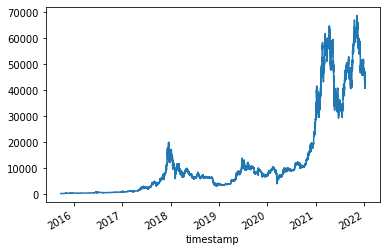

In [26]:
df_bitmex["close"].plot()

In [31]:
# df_bitmex["date"] = 
df_bitmex["date"] = pd.to_datetime(df_bitmex.index)
df_bitmex["year"] = df_bitmex.date.dt.year

df_bitmex["year"].value_counts()

2016    8784
2020    8784
2017    8760
2018    8760
2019    8760
2021    8760
2015    2339
2022     209
Name: year, dtype: int64

In [20]:
df_binance = get_all_binance("BTCBUSD", "1h")

Exception ignored in: <function tqdm.__del__ at 0x0000021B3F12ED40>
Traceback (most recent call last):
  File "C:\Python310\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Python310\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


All caught up..!


In [21]:
df_binance

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2019-09-19 10:00:00,9881.43000000,9881.43000000,9828.59000000,9849.75000000,0.05688900,1568890799999,560.65782142,10,0.01979900,195.33354240,0
2019-09-19 11:00:00,9849.75000000,9849.75000000,9849.75000000,9849.75000000,0.00000000,1568894399999,0.00000000,0,0.00000000,0.00000000,0
2019-09-19 12:00:00,9848.41000000,9858.85000000,9848.41000000,9858.85000000,0.02113800,1568897999999,208.33128420,4,0.01983800,195.52835120,0
2019-09-19 13:00:00,9870.06000000,9887.21000000,9866.53000000,9866.53000000,0.01252500,1568901599999,123.60879550,3,0.00129000,12.75450090,0
2019-09-19 14:00:00,9866.53000000,9866.53000000,9866.53000000,9866.53000000,0.00000000,1568905199999,0.00000000,0,0.00000000,0.00000000,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-09 12:00:00,41862.93000000,41923.67000000,41681.06000000,41752.69000000,201.32839000,1641733199999,8408025.93533400,11048,111.93234000,4673764.46179980,0
2022-01-09 13:00:00,41752.69000000,41897.19000000,41478.37000000,41479.06000000,328.90721000,1641736799999,13700742.23196730,14568,148.33160000,6179755.31660100,0
2022-01-09 14:00:00,41479.06000000,41737.54000000,41479.06000000,41536.48000000,181.10498000,1641740399999,7535054.60224730,10164,91.11406000,3790926.45682140,0


In [54]:
df_binance_tether = get_all_binance("BTCUSDT", "1h", save=True)

All caught up..!


In [23]:
df_binance_tether

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-08-17 04:00:00,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900,1502945999999,202366.13839304,171,35.16050300,150952.47794304,7887.63551305
2017-08-17 05:00:00,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600,1502949599999,100304.82356749,102,21.44807100,92608.27972836,8039.26240152
2017-08-17 06:00:00,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100,1502953199999,31282.31266989,36,4.80286100,20795.31722405,8041.76049845
2017-08-17 07:00:00,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900,1502956799999,19241.05829986,25,2.60229200,11291.34701534,8048.12788573
2017-08-17 08:00:00,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700,1502960399999,4239.50358563,28,0.81465500,3552.74681715,8018.03650010
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-09 12:00:00,41857.62000000,41923.39000000,41665.46000000,41746.98000000,553.97717000,1641733199999,23140750.06692080,23881,233.18310000,9740457.68601850,0
2022-01-09 13:00:00,41746.98000000,41894.01000000,41469.48000000,41470.00000000,922.91336000,1641736799999,38454040.52575920,29083,383.44733000,15978362.06566190,0
2022-01-09 14:00:00,41470.00000000,41743.26000000,41469.99000000,41535.93000000,628.73613000,1641740399999,26162633.34154910,23823,335.55638000,13962599.97007880,0


In [34]:
df_binance_tether["date"] = pd.to_datetime(df_binance_tether.index)
df_binance_tether["year"] = df_binance_tether.date.dt.year

df_binance_tether["year"].value_counts()

2020    8767
2021    8747
2019    8732
2018    8699
2017    3277
2022     209
Name: year, dtype: int64